# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Yuqing"
ln1 = "WANG"
fn2 = "Zhengkang"
ln2 = "SHI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_wang_yuqing_and_shi_zhengkang.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

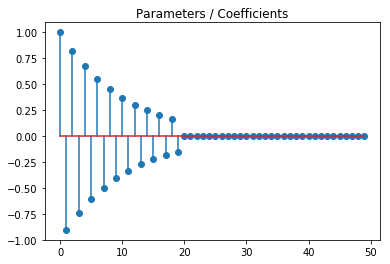

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [6]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x""" 
    return np.sign(x)*np.maximum(np.zeros(x.size),abs(x)-s)
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * np.linalg.norm(x, 1)

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x""" 
    return x / (1+s) 
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return s * np.square(np.linalg.norm(x,2)) / 2

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

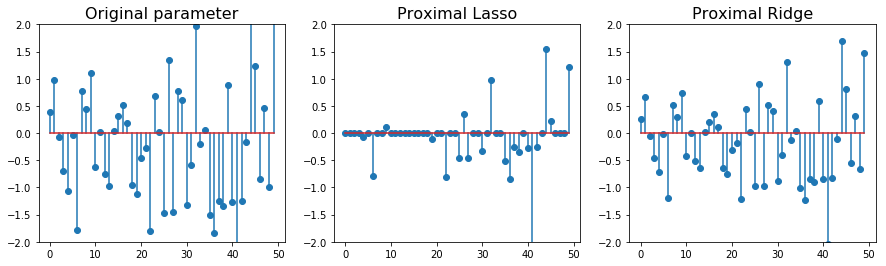

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

### We can see that:
### Ridge: It performs coefficient shrinkage and includes all of the features in the model.
### Lasso: Along with shrinking coefficients, lasso performs feature selection as well. 

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [8]:
def create_linreg():
    global A, b
    A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
    def loss_linreg(x):   
        """Least-squares loss"""
        n = A.shape[0]
        return np.linalg.norm(A.dot(x) - b) ** 2 / (2. * n)
    
    def grad_linreg(x):  
        """Leas-squares gradient"""
        # TODO
        n = A.shape[0]
        return A.T.dot(A.dot(x) - b) / n
    
    return loss_linreg, grad_linreg

def create_logreg():
    global A, b
    A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
    def loss_logreg(x):     
        """Logistic loss"""
        # TODO
        bAx = b * np.dot(A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) 
    
    def grad_logreg(x):   
        """Logistic gradient"""
        # TODO
        n = A.shape[0]
        bAx = b * np.dot(A, x)
        temp = 1/(1+np.exp(bAx))
        return -(A.T).dot(b * temp) / n 
    
    return loss_logreg, grad_logreg

Check that these functions are correct by numerically checking the gradient.

In [9]:
x = randn(50)
from scipy.optimize import check_grad
loss_linreg, grad_linreg = create_linreg()
loss_logreg, grad_logreg = create_logreg()
print(check_grad(loss_linreg, grad_linreg, x))
print(check_grad(loss_logreg, grad_logreg, x))

1.362861186618862e-06
1.3288534157351847e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [10]:
# TO BE COMPLETED

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    n = A.shape[0]
    return np.linalg.norm(A, 2) ** 2 / n
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    n = A.shape[0]
    return np.linalg.norm(A, 2) ** 2  / (4. * n)
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True, lin=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    #A = A_linreg
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        if lin:
            L = lip_linreg(A) + s
        else:
            L = lip_logreg(A) + s
        x_new = prox_g(x - 1/L * grad_f(x), s/L ) 
        x = x_new
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [11]:
# TO BE COMPLETED

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True, lin=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        if lin:
            L = lip_linreg(A) + s
        else:
            L = lip_logreg(A) + s
        x_new = prox_g(z - 1/L * grad_f(z), s/L)
        t_new = (1+np.sqrt(1+4*np.square(t)))/2
        z_new = x_new+(t-1)/t_new*(x_new-x)
        x = x_new
        t = t_new
        z = z_new
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [12]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

Compute a precise minimum and a precise minimizer of the linear regression with ridge penalization problem.

In [13]:
f, f_grad = create_linreg()
x, objectives, errors = fista(x0, f, f_grad, ridge, prox_ridge, step=1, s=1e-2, n_iter=40, x_true=coefs, verbose=True)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.32e+00 | 8.76e-01
      10 | 4.80e-01 | 1.22e-01
      20 | 4.79e-01 | 1.27e-01
      30 | 4.79e-01 | 1.21e-01
      40 | 4.79e-01 | 1.23e-01


In [14]:
print("precise minimium:")
print(objectives[-1])
print("precise minimizer:")
print(x)

precise minimium:
0.4788073218769456
precise minimizer:
[ 1.02e+00 -9.29e-01  8.05e-01 -7.14e-01  6.87e-01 -5.55e-01  5.26e-01
 -4.80e-01  4.73e-01 -4.78e-01  4.18e-01 -3.64e-01  3.78e-01 -2.87e-01
  2.49e-01 -2.47e-01  2.12e-01 -2.02e-01  1.74e-01 -6.87e-02 -4.29e-02
 -1.48e-02  4.04e-03  4.56e-02  5.35e-02 -3.35e-02  2.24e-02 -4.65e-02
  1.68e-02 -2.50e-02  3.17e-02 -4.45e-02  6.90e-02  3.70e-02 -4.84e-03
 -3.27e-02  2.04e-02  4.44e-02 -2.97e-02  8.36e-02 -8.91e-02  1.96e-02
 -7.41e-02  5.46e-02 -5.11e-05  3.46e-02 -3.81e-03 -3.82e-02  3.84e-02
 -2.77e-02]


Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer.

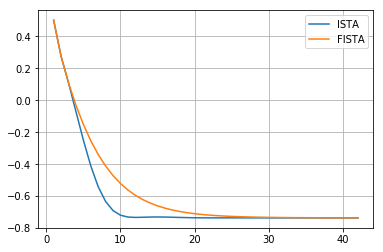

In [15]:
x_1, objectives_1, errors_1 = ista(x0, f, f_grad, ridge, prox_ridge, step=1, s=1e-2, n_iter=40, x_true=coefs, verbose=False)
x_axis = np.arange(1, n_iter+3)
plt.plot(x_axis, np.log(np.array(objectives)), label = 'ISTA')
plt.plot(x_axis, np.log(np.array(objectives_1)), label = 'FISTA')
plt.grid()
plt.legend()
plt.show()

### We can see that FISTA converges significantly faster than ISTA. Because the difference between FISTA and ISTA is only the choice of the starting point of the approximate function at each iteration. To be more concise: FISTA uses a more intelligent approach to select the sequence {xk}, making its iterative process approach the minimum more quickly.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

Compare the solution with ista and fista with the true parameter coefs of the model.

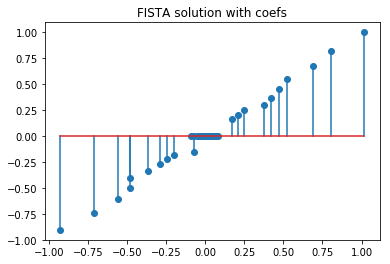

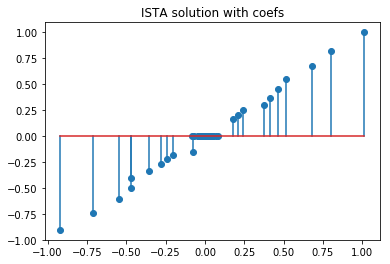

In [16]:
plt.stem(x.reshape(-1,1), coefs)
plt.title('FISTA solution with coefs')
plt.show()
plt.stem(x_1.reshape(-1,1), coefs)
plt.title('ISTA solution with coefs')
plt.show()

In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. 

In [17]:
f, f_grad = create_logreg()
x_2, objectives_2, errors_2 = fista(x0, f, f_grad, ridge, prox_ridge, step=1, s=1e-2, n_iter=40, x_true=coefs, verbose=False, lin=False)

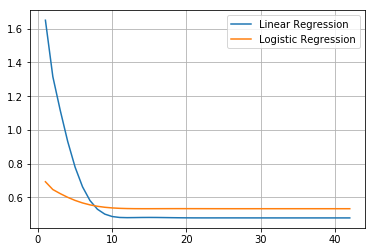

In [18]:
x_axis = np.arange(1, n_iter+3)
plt.plot(x_axis, np.array(objectives), label = 'Linear Regression')
plt.plot(x_axis, np.array(objectives_2), label = 'Logistic Regression')
plt.grid()
plt.legend()
plt.show()

### We can see that the linear regression acts better because the logistic regression is sensitive to the correlation of independent variables in the model.

In linear regression and logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms. 

In [19]:
f, f_grad = create_linreg()
obj_lin = []
for i in np.arange(0.1, 1.0, 0.1):
    _, temp, _ = fista(x0, f, f_grad, ridge, prox_ridge, step=1, s=i, n_iter=40, x_true=coefs, verbose=False)
    obj_lin.append(temp[-1])
obj_lin = np.array(obj_lin)

In [20]:
f, f_grad = create_logreg()
obj_log = []
for i in np.arange(0.1, 1.0, 0.1):
    _, temp, _ = fista(x0, f, f_grad, ridge, prox_ridge, step=1, s=i, n_iter=40, x_true=coefs, verbose=False, lin=False)
    obj_log.append(temp[-1])
obj_log = np.array(obj_log)

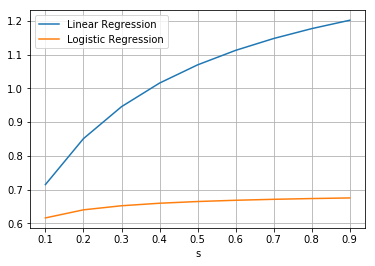

In [21]:
x_axis = np.arange(0.1, 1.0, 0.1)
plt.plot(x_axis, obj_lin, label='Linear Regression')
plt.plot(x_axis, obj_log, label='Logistic Regression')
plt.grid()
plt.xlabel('s')
plt.legend()
plt.show()

### We can see that the logistic regression acts better as the penalizations  being larger because of the influence of Lipschitz constants. 

In linear regression and logistic regression, compare the performance of the optimization algorithms for ridge and lasso penalizations

In [22]:
x0 = np.zeros(n_features)
f, f_grad = create_linreg()
x_3, objectives_3, errors_3 = fista(x0, f, f_grad, lasso, prox_lasso, step=1, s=1e-2, n_iter=40, x_true=coefs, verbose=False)
f, f_grad = create_logreg()
x_4, objectives_4, errors_4 = fista(x0, f, f_grad, lasso, prox_lasso, step=1, s=1e-2, n_iter=40, x_true=coefs, verbose=False, lin=False)

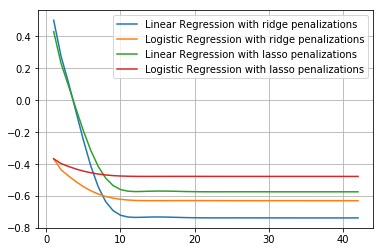

In [23]:
x_axis = np.arange(1, n_iter+3)
plt.plot(x_axis, np.log(np.array(objectives)), label='Linear Regression with ridge penalizations')
plt.plot(x_axis, np.log(np.array(objectives_2)), label='Logistic Regression with ridge penalizations')
plt.plot(x_axis, np.log(np.array(objectives_3)), label='Linear Regression with lasso penalizations')
plt.plot(x_axis, np.log(np.array(objectives_4)), label='Logistic Regression with lasso penalizations')
plt.grid()
plt.legend()
plt.show()

### we can see the linear regression converges faster than logistic regression, the ridge penalization converges faster than lasso penalization. we can explain it by the reason below:
### Ridge: It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.
### Lasso: It arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. Also, the chosen variable changes randomly with change in model parameters. This generally doesn’t work that well as compared to ridge regression.